# Get FF_estimation_scalar MSDCV

Make sure that analysis_estimation_nds.py imports FF_estimation_scalar, and that batch_size = 100 in model_settings.py.

In [1]:
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import analysis_estimation_nds
import importlib
importlib.reload(analysis_estimation_nds)
from jupyterthemes import jtplot
jtplot.style()
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

['/home/sychen23/.local/lib/python3.5/site-packages/ipykernel_launcher.py', '-f', 'true', 'true', 'true', 'true', 'true', 'model_runs/-f/classify_log.csv', 'model_runs/-f/classifymodel_0.ckpt', 'model_runs/-f/classifymodel_', 'model_runs/-f/zzzdraw_data_5000.npy', 'false', 'true', 'false', 'false', 'true']
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
analysis_estimation_nds.py
analysis_estimation_nds.py


Choose which model is of interest, specify the test condition and if the data is created incrementally, specify the results directory, and set scalar to True and specify if the results should be rounded.

In [2]:
models = [("New_CAA_const_fN_scalar", "Const Avg Area, $f(n)$ Constant"),
          ("New_CAA_decrs_fN_scalar", "Const Avg Area, $f(n) \propto 1/n^2$"),
          ("New_DAA_const_fN_scalar", "Decr Avg Area, $f(n)$ Constant"),
          ("New_DAA_decrs_fN_scalar", "Decr Avg Area, $f(n) \propto 1/n^2$")]
model = models[3]
model_name, model_figure_title = model
num_runs = 10
iter_list = [0, 200, 400, 1600, 6400, 25600, 102400, 204800, 409600, 819200, 1000000, 1228800, 1638400, 2000000, 3000000]#, 4000000, 5000000, 6000000]
max_blobs = 9
min_blobs = 1

num_iters = len(iter_list)
output_size = max_blobs - min_blobs + 1
test_condition = "po_ind"
incremental = False
data_directory = "data/" + model_name + "/" + test_condition + "/"

import os
if not os.path.exists(data_directory):
    os.makedirs(data_directory)
    
from pathlib import Path
results_dir = 'Results/20200307_msdcv_3000000_scalar/unrounded/' + test_condition + "/"
Path(results_dir).mkdir(parents=True, exist_ok=True)
scalar = True
rounded = False

In [3]:
from tensorflow.python.tools.inspect_checkpoint import print_tensors_in_checkpoint_file
import os
path = 'model_runs/' + model_name + str(1)
it = 0
checkpoint_path = "%s/classifymodel_%d.ckpt" % (path, it)

# List ALL tensors example output: v0/Adam (DT_FLOAT) [3,3,1,80]
print_tensors_in_checkpoint_file(file_name=checkpoint_path, tensor_name='', all_tensors=False, all_tensor_names=False)

# List contents of v0 tensor.
# Example output: tensor_name:  v0 [[[[  9.27958265e-02   7.40226209e-02   4.52989563e-02   3.15700471e-02
# print_tensors_in_checkpoint_file(file_name=checkpoint_path, tensor_name='hidden/b', all_tensors=False, all_tensor_names=False)


beta1_power (DT_FLOAT) []
beta2_power (DT_FLOAT) []
hidden/b (DT_FLOAT) [250]
hidden/b/Adam (DT_FLOAT) [250]
hidden/b/Adam_1 (DT_FLOAT) [250]
hidden/w (DT_FLOAT) [225,250]
hidden/w/Adam (DT_FLOAT) [225,250]
hidden/w/Adam_1 (DT_FLOAT) [225,250]
output/b (DT_FLOAT) [1]
output/b/Adam (DT_FLOAT) [1]
output/b/Adam_1 (DT_FLOAT) [1]
output/w (DT_FLOAT) [250,1]
output/w/Adam (DT_FLOAT) [250,1]
output/w/Adam_1 (DT_FLOAT) [250,1]



In [4]:
path = 'model_runs/' + model_name + str(1)
imgs_data = analysis_estimation_nds.classify_imgs_po(0, True, 100, path=path, incremental=incremental, scalar=scalar)
print(np.shape(imgs_data[1]["classifications"]))
print(imgs_data[1]["classifications"][0])
print(imgs_data[1]["classifications"][0][0]) # scalar output

INFO:tensorflow:Restoring parameters from model_runs/New_DAA_decrs_fN_scalar1/classifymodel_0.ckpt
(1, 1)
[-2.618962]
-2.618962


In [5]:
def get_classifications_one_run(path, iteration):
    """Get classifications for one run at one iteration."""

    imgs_data = analysis_estimation_nds.classify_imgs_po(iteration, True, 100, path=path, incremental=incremental, scalar=scalar) # new_imgs = True
    unrounded_values = {nb: [] for nb in range(1, output_size+1)}
    rounded_values = {nb: [] for nb in range(1, output_size+1)}
    
    for idx, data in enumerate(imgs_data):
        nb = data["label"][0]
        classification = data["classifications"][0][0]
        unrounded_values[nb].append(classification)
        rounded_values[nb].append(round(classification))
    return unrounded_values, rounded_values

In [6]:
unrounded_values_all_runs = []
rounded_values_all_runs = []

for run in range(num_runs):
    path = 'model_runs/' + model_name + str(run + 1) # '/run_' if all the runs are stored in one folder
    unrounded_values_all_iters = []
    rounded_values_all_iters = []
    for i, iteration in enumerate(iter_list):
        uvals, rvals = get_classifications_one_run(path, iteration)
        unrounded_values_all_iters.append(uvals)
        rounded_values_all_iters.append(rvals)
    unrounded_values_all_runs.append(unrounded_values_all_iters)
    rounded_values_all_runs.append(rounded_values_all_iters)
    
with open(data_directory + 'unrounded_values_all_runs', 'wb') as fp:
    pickle.dump(unrounded_values_all_runs, fp)
    
with open(data_directory + 'rounded_values_all_runs', 'wb') as fp:
    pickle.dump(rounded_values_all_runs, fp) 

INFO:tensorflow:Restoring parameters from model_runs/New_DAA_decrs_fN_scalar1/classifymodel_0.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_DAA_decrs_fN_scalar1/classifymodel_200.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_DAA_decrs_fN_scalar1/classifymodel_400.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_DAA_decrs_fN_scalar1/classifymodel_1600.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_DAA_decrs_fN_scalar1/classifymodel_6400.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_DAA_decrs_fN_scalar1/classifymodel_25600.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_DAA_decrs_fN_scalar1/classifymodel_102400.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_DAA_decrs_fN_scalar1/classifymodel_204800.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_DAA_decrs_fN_scalar1/classifymodel_409600.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_DAA_decrs_fN_scalar1/cl

INFO:tensorflow:Restoring parameters from model_runs/New_DAA_decrs_fN_scalar6/classifymodel_25600.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_DAA_decrs_fN_scalar6/classifymodel_102400.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_DAA_decrs_fN_scalar6/classifymodel_204800.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_DAA_decrs_fN_scalar6/classifymodel_409600.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_DAA_decrs_fN_scalar6/classifymodel_819200.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_DAA_decrs_fN_scalar6/classifymodel_1000000.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_DAA_decrs_fN_scalar6/classifymodel_1228800.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_DAA_decrs_fN_scalar6/classifymodel_1638400.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_DAA_decrs_fN_scalar6/classifymodel_2000000.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_DAA_

In [7]:
def get_msdcv(classifications_list):
    """Get the mean, standard deviation, and coefficient of variation matrices from classifications list."""
    
    msdcv = np.zeros([num_iters, output_size, 3])    
    values = [{nb: [] for nb in range(1, output_size+1)} for i in range(num_iters)] # iter x nb x value
    for run in range(num_runs):
        for i in range(num_iters):
            for t in range(output_size):
                nb = t + 1
                if nb in classifications_list[run][i]:
                    values[i][nb] += classifications_list[run][i][nb]
    for i in range(num_iters):
        for t in range(output_size):
            nb = t + 1
            vals = values[i][nb]
            msdcv[i, t, 0] = mu = np.mean(vals)
            msdcv[i, t, 1] = sigma = np.std(vals)
            msdcv[i, t, 2] = cv = sigma / mu
    return msdcv

In [8]:
unrounded_msdcv = get_msdcv(unrounded_values_all_runs)
rounded_msdcv = get_msdcv(rounded_values_all_runs)

In [9]:
np.save(data_directory + "unrounded_msdcv", unrounded_msdcv)
np.save(data_directory + "rounded_msdcv", rounded_msdcv)

## Visualize Mean, Standard Deviation, and Coefficient of Variation

Run 20200202_Plot_MSDCV_scalar.ipynb to get plots. Below is an example plot.

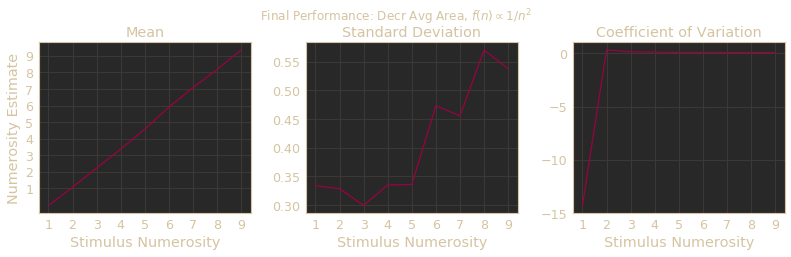

In [10]:
all_iters = [0, 200, 400, 1600, 6400, 6400, 102400, 204800, 409600, 819200, 1000000, 1228800, 1638400, 2000000, 3000000]#, 4000000, 5000000, 6000000]
iters = [3000000]
iter_indices = [i for i, iteration in enumerate(all_iters) if iteration in iters]
max_blobs = 9
min_blobs = 1
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(3.7*3, 3.6))
from matplotlib.ticker import MaxNLocator
plt.xticks(np.arange(min_blobs, max_blobs+1, step=1))
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[2].xaxis.set_major_locator(MaxNLocator(integer=True))
numerosity = np.arange(min_blobs, max_blobs+1)

ax[0].set_title("Mean")
ax[0].set_xlabel("Stimulus Numerosity")
ax[0].set_ylabel("Numerosity Estimate")
ax[0].set_yticks(np.arange(min_blobs, max_blobs+1, step=1))
ax[0].set_xticks(np.arange(min_blobs, max_blobs+1, step=1))
ax[0].set_prop_cycle('color',plt.cm.Spectral([val for val in np.linspace(0,1,len(iter_indices)) for _ in (0,1)]))

ax[1].set_title("Standard Deviation")
ax[1].set_xlabel("Stimulus Numerosity")
ax[1].set_xticks(np.arange(min_blobs, max_blobs+1, step=1))
ax[1].set_prop_cycle('color',plt.cm.Spectral([val for val in np.linspace(0,1,len(iter_indices)) for _ in (0,1)]))

ax[2].set_title("Coefficient of Variation")
ax[2].set_xlabel("Stimulus Numerosity")
# ax[2].set_yticks(np.arange(0, 1, step=0.02))
ax[2].set_xticks(np.arange(min_blobs, max_blobs+1, step=1))
ax[2].set_prop_cycle('color',plt.cm.Spectral([val for val in np.linspace(0,1,len(iter_indices)) for _ in (0,1)]))

for i in iter_indices:
    mean = unrounded_msdcv[i,min_blobs-1:max_blobs,0]
    sd = unrounded_msdcv[i,min_blobs-1:max_blobs+1,1]
    cv = unrounded_msdcv[i,min_blobs-1:max_blobs+1,2]

    # Plot Mean.
    ax[0].plot(numerosity, mean, label='N')
    
    # Plot SD.
    ax[1].plot(numerosity, sd, label='N')
    
    # Plot CV.
    ax[2].plot(numerosity, cv, label='N')

# legend = ax[i, 1].legend()
fig.tight_layout()
fig.suptitle("Final Performance: %s" % model_figure_title)
plt.tight_layout(rect=[0, 0, 1, 0.95])
from pathlib import Path
plt.savefig(results_dir + model_name + '.png')
plt.show()

In [11]:
unrounded_msdcv.shape

(15, 9, 3)